# Static Network Generation - with age group

In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Point
import nafot
import time
from tqdm import tqdm, tqdm_notebook
import networkx as nx
import pickle
from itertools import product
plt.style.use('ggplot')
%matplotlib inline

## Load the data

In [2]:
# Get the statistical area GeoDataFrame
gdf = nafot.gdf.copy()

# Loading the contact matrices
contact_matrix = pd.read_pickle('../data/matrix/contact_matrix_final_with_age.pickle')
contact_matrix_yeshuv = pd.read_pickle('../data/matrix/contact_matrix_final_with_age_yeshuv.pickle')
contact_matrix_subdist = pd.read_pickle('../data/matrix/contact_matrix_final_with_age_subdist.pickle')

# Setting index, dtype and replacing nan with 0
# Stat area contact matrix
contact_matrix.fillna(0, inplace=True)
# Yeshuv contact matrix
contact_matrix_yeshuv.fillna(0, inplace=True)
# Subdist contact matrix
contact_matrix_subdist.fillna(0, inplace=True)

# Get the population of the relevant areas
population_dict = {(area, age):
                   gdf.loc[area].pop_thou * gdf.loc[area].age0_17_pcnt * 1000 if age == 0 else
                   gdf.loc[area].pop_thou * (1 - gdf.loc[area].age0_17_pcnt) * 1000
                   for area, age in contact_matrix.columns}

# Calculate population proportion
pop_proportion_dict = {(area, age): population_dict[(area, age)]/sum(population_dict.values())
                       for area, age in population_dict.keys()}

# Loading the sparse area dict
with open('../data/sparse_areas_with_age.pickle','rb') as pickle_in:
    sparse_area_dict = pickle.load(pickle_in)
    
# Get hierarchical lists of subdists and yeshuvim
yeshuv_stat_areas = nafot.get_hierarchical_list('yeshuv')
subdist_stat_areas = nafot.get_hierarchical_list('subdistrict')

# Remove irrelevant stat areas - yeshuv
for yeshuv, stat_area_list in yeshuv_stat_areas.items():
    stat_area_list_with_age = list(product(stat_area_list, [0,1]))[:]
    for stat_area, age in stat_area_list_with_age[:]:
        if (stat_area, age) not in contact_matrix.index:
            stat_area_list_with_age.remove((stat_area, age))
    yeshuv_stat_areas[yeshuv] = stat_area_list_with_age

# Remove irrelevant stat areas - subdistrict    
for subdist, stat_area_list in subdist_stat_areas.items():
    stat_area_list_with_age = list(product(stat_area_list, [0,1]))[:]
    for stat_area, age in stat_area_list_with_age[:]:
        if (stat_area, age) not in contact_matrix.index:
            stat_area_list_with_age.remove((stat_area, age))
    subdist_stat_areas[subdist] = stat_area_list_with_age
    
# Get reverse hierarchical list
stat_areas_subdist = {area: gdf.loc[area]['SubDistrictCode'] for area, age in contact_matrix.index}

# FIX

In [3]:
# Number of contacts distriution
mean = np.array([15, 12])
p = 1/mean

### Helper Functions

In [4]:
# gen_nodes_dict = nodes_by_area.copy()
def add_contact(network, node, individual, con_location=None, higher_level=None): 
    # Iterate over the individuals to be connected with
#     if (node, individual) in network.edges:
#         print ('Contact already exsists',  (node, individual))
    
    # Add the edge and update the number of remaining contacts
    network.add_edge(node, individual)#, location=con_location)

    # Update nodes remainig contacts and dist
    update_node_contact(node, network.nodes[individual]['area'], network.nodes[individual]['age'], higher_level=higher_level)
    update_node_contact(individual, network.nodes[node]['area'], network.nodes[node]['age'], higher_level=higher_level)

def update_node_contact(node, contact_area, contact_age, higher_level=False):
    # Update remaining_contacts
    network.nodes[node]['remaining_contacts'] -= 1
    
    # Update remaining_contact_distribution
    if not higher_level:
        network.nodes[node]['remaining_contact_dist'][(contact_area, contact_age)] -= 1 
    
    # If using higer level
    else:
        contact_subdist = stat_areas_subdist[contact_area]
        for (cur_area, cur_age), _ in network.nodes[node]['remaining_contact_dist'].iteritems():
            if stat_areas_subdist[cur_area] == contact_subdist:
                network.nodes[node]['remaining_contact_dist'][(cur_area, cur_age)] -= 1
                break
    
    # If one of the areas in remaining_contact_dist is now 0, remove it
    network.nodes[node]['remaining_contact_dist'] =\
                    network.nodes[node]['remaining_contact_dist'][network.nodes[node]['remaining_contact_dist']>0]
        
    # If the number of remaining contacts is now zero - remove from meeting_gen_dict and update gen_pop_dict
    if network.nodes[node]['remaining_contacts'] == 0:
        # Update nodes_dict
        if np.argwhere(nodes_by_area_age[(contact_area, contact_age)]==node).size == 0:
            nodes_by_area_age[(contact_area, contact_age)] =\
            np.delete(nodes_by_area_age[(contact_area, contact_age)], np.argwhere(nodes_by_area_age[(contact_area, contact_age)]==node))

def get_candidates(origin_node, dest_area, dest_age ,cand_number, higher_level=False):
    """Get candidates nodes given origin node and destenation area and age.
    The candidates are nodes from the destenation area and age
    which has a remaining potential contact with the origin area and age"""
    # Initialize a list for the candidates
    candidates = []
    
    if not higher_level:
        origin_area = network.nodes[origin_node]['area']
        origin_age = network.nodes[origin_node]['age']
        nodes = nodes_by_area_age[(dest_area, dest_age)].copy()
        np.random.shuffle(nodes)
        
        for n in nodes:
            if (origin_area, origin_age) in set(network.nodes[n]['remaining_contact_dist'].index) and \
            (n != origin_node) and (n not in network[origin_node]):
                candidates.append(n)
                if len(candidates) >= cand_number:
                    break
    
    # If using higher level
    else:
        origin_subdist = network.nodes[origin_node]['subdist']
        origin_age = network.nodes[origin_node]['age']
        nodes = nodes_by_subdist_age[(stat_areas_subdist[dest_area], dest_age)].copy()
        np.random.shuffle(nodes)
        
        for n in nodes:
            destenation_subdists = set([stat_areas_subdist[area] for area, age in set(network.nodes[n]['remaining_contact_dist'].index)])
            if (origin_subdist in destenation_subdists) and (n != origin_node) and (n not in network[origin_node]):
                candidates.append(n)
                if len(candidates) >= cand_number:
                    break
   
    return candidates        

def calculate_number_of_contacts(network):
    total_contacts, total_remaning_contacts = 0,0
    for n in network.nodes:
        node = network.nodes[n]
        total_contacts += node['contacts']
        total_remaning_contacts += node['remaining_contacts']
    
    return total_contacts, total_remaning_contacts        

## Generate a Static Network

### Generate initial population

In [5]:
np.random.seed(1)

# Set the simulated population size
population_size = 1e5

# Set the population size of each area and age group according to the real population distribution
simulation_pop_dict = {(area, age): int(pop_proportion_dict[(area, age)]*population_size)
                       for area, age in population_dict.keys()}

# Intialize a dictionary for nodes by area and age
nodes_by_area_age = {(area, age): np.array([]) for area, age in population_dict.keys()}

# Intialize a Graph object
network = nx.Graph(pop_size=population_size)

# Add a node for each individual from each area and age group
n = 0
for (area, age), pop in tqdm(simulation_pop_dict.items()):
    # Save the nodes numbers to nodes_by_area dict
    nodes_by_area_age[(area, age)] = np.arange(n,n+pop)
    
    for i in range(pop):
        # Generate number of contacts
        num_of_contacts = np.random.geometric(p[age])
 
        # Add the node to the network (with the relevant area, age and number of contacts)
        network.add_node(n, area=area, age=age, contacts=num_of_contacts, remaining_contacts=num_of_contacts)
        node = network.nodes[n]
        # Add the node's subdist
        node['subdist'] = stat_areas_subdist[area]
        
        # If area and age is not sparse
        if (area, age) not in sparse_area_dict:
            # Get the number of contacts from each area and age - using a Multinomial distribution
            contacts = np.random.multinomial(n=num_of_contacts, pvals=contact_matrix.loc[[(area, age)]].values[0])

            # Save the non-zero contacts
            contact_dist = pd.Series(contacts, index=contact_matrix.index, name=n)
            contact_dist = contact_dist[contact_dist>0]
        
        # If area is sparse
        else:
            if sparse_area_dict[(area, age)][0] == 'subdistrict':
                contacts_sparse = np.random.multinomial(n=num_of_contacts, pvals=contact_matrix_subdist.loc
                                                        [[sparse_area_dict[(area, age)][1]]].values[0])
                contact_sparse_dist = pd.Series(contacts_sparse, index=contact_matrix_subdist.index, name=n)
                contact_sparse_dist = contact_sparse_dist[contact_sparse_dist>0]
                
            else: 
                contacts_sparse = np.random.multinomial(n=num_of_contacts, pvals=contact_matrix_yeshuv.loc
                                                        [[sparse_area_dict[(area, age)][1]]].values[0])
                contact_sparse_dist = pd.Series(contacts_sparse, index=contact_matrix_yeshuv.index, name=n)
                contact_sparse_dist = contact_sparse_dist[contact_sparse_dist>0]
        
            # Generate a stat area from the relevant yeshuv/subdist
            new_contact_dict = {}
            
            # Go over the contacts (in yeshuv/subdist level) and sample a stat area form the yeshuv/subdist
            for cont, amount in contact_sparse_dist.iteritems():
                if sparse_area_dict[(area, age)][0] == 'yeshuv':
                    new_cont_idx = np.random.choice(range(len(yeshuv_stat_areas[cont[0]])), size=amount, replace=True)
                    new_cont = [yeshuv_stat_areas[cont[0]][i] for i in new_cont_idx]
                else:
                    new_cont_idx = np.random.choice(range(len(subdist_stat_areas[cont[0]])), size=amount, replace=True)
                    new_cont = [subdist_stat_areas[cont[0]][i] for i in new_cont_idx]

                
                # Save the number of contacts from each stat area to a dict
                for c in new_cont:
                    new_contact_dict[c] = new_contact_dict.get(c, 0) + 1
            
            # Update the final contact distribution
            contact_dist = pd.Series(new_contact_dict, dtype='int32', name=n)

        # Add the contact distribution to the node as an attribute
        node['contact_dist'] = contact_dist.copy()
        node['remaining_contact_dist'] = contact_dist.copy()
        
        # Incease n by 1
        n+=1

# Create nodes by subdistrict and age dictionary
nodes_by_subdist_age = {(subdist, age): np.array([]) for subdist, age in contact_matrix_subdist.index}
for (area, age), node_list in nodes_by_area_age.items():
    cur_subdist = stat_areas_subdist[area]
    nodes_by_subdist_age[(cur_subdist, age)] = np.append(nodes_by_subdist_age[(cur_subdist, age)], [node_list])

100%|██████████████████████████████████████████████████████████████████████████████| 2049/2049 [02:41<00:00, 12.72it/s]


### Connect the nodes

In [6]:
counter = 0
# Iterate over the nodes
for n in tqdm(network.nodes):
    node = network.nodes[n]
    
    # If there are no remaining contacts - continue to the next node
    if node['remaining_contacts'] == 0:
        continue
        
    contacts = node['remaining_contact_dist']
    
    for (area, age), num_of_con in contacts.iteritems():
        contact_candidates =  get_candidates(origin_node=n, dest_area=area, dest_age=age, cand_number=num_of_con)
        if len(contact_candidates) > 0:
            # The possible num of contact is the minimum between what is needed and the number of candidates
            possible_contacts_num = min(node['remaining_contacts'], num_of_con, len(contact_candidates))
            # Choose the individuals to contact from the candidates
            chosen_individuals = np.random.choice(contact_candidates, size=possible_contacts_num, replace=False)
            # Add edges
            for individual in chosen_individuals:
                add_contact(network, n, individual)
                counter+=1

100%|███████████████████████████████████████████████████████████████████████████| 99008/99008 [12:57<00:00, 127.35it/s]


#### Add remaining contacts by higher level

In [7]:
# Iterate over the nodes
for n in tqdm(network.nodes):
    node = network.nodes[n]
    
    # If there are remaining contacts
    if node['remaining_contacts'] > 0:
        contacts = node['remaining_contact_dist']
        
        for (area, age), num_of_con in contacts.iteritems():
            contact_candidates =  get_candidates(origin_node=n, dest_area=area, dest_age=age, cand_number=num_of_con,
                                                 higher_level=True)
            if len(contact_candidates) > 0:
                # The possible num of contact is the minimum between what is needed and the number of candidates
                possible_contacts_num = min(node['remaining_contacts'] ,num_of_con, len(contact_candidates))
                # Choose the individuals to contact from the candidates
                chosen_individuals = np.random.choice(contact_candidates, size=possible_contacts_num, replace=False)
                # Add edges
                for individual in chosen_individuals:
                    add_contact(network, n, individual, higher_level=True)
                    counter += 1

100%|██████████████████████████████████████████████████████████████████████████| 99008/99008 [2:43:41<00:00, 10.08it/s]


In [8]:
print(f'Theoretical contacts: {calculate_number_of_contacts(network)[0]:,d}\n\
Total remaining contacts: {calculate_number_of_contacts(network)[1]:,d}\n\
Existing contacts = Theoretical contacts - Total remaining contacts: {calculate_number_of_contacts(network)[0]-calculate_number_of_contacts(network)[1]:,d}\n\
Number of edges: {network.number_of_edges():,d} ; \
2*Number of edges: {2*network.number_of_edges():,d}\n\
Numbers of calls to add_contact(): {counter:,d} ; \
2*Numbers of calls to add_contact(): {2*counter:,d}')

Theoretical contacts: 1,272,124
Total remaining contacts: 60,386
Existing contacts = Theoretical contacts - Total remaining contacts: 1,211,738
Number of edges: 605,869 ; 2*Number of edges: 1,211,738
Numbers of calls to add_contact(): 605,869 ; 2*Numbers of calls to add_contact(): 1,211,738


### Save the network

In [9]:
# Save the network to gpickle
nx.write_gpickle(network, "../../Data/network/static_network_with_age_100K.gpickle")

In [13]:
# Read the network from gpickle
# x = nx.read_gpickle("../../Data/network/static_network.gpickle")

## Network Characteristics

### Degree distribution

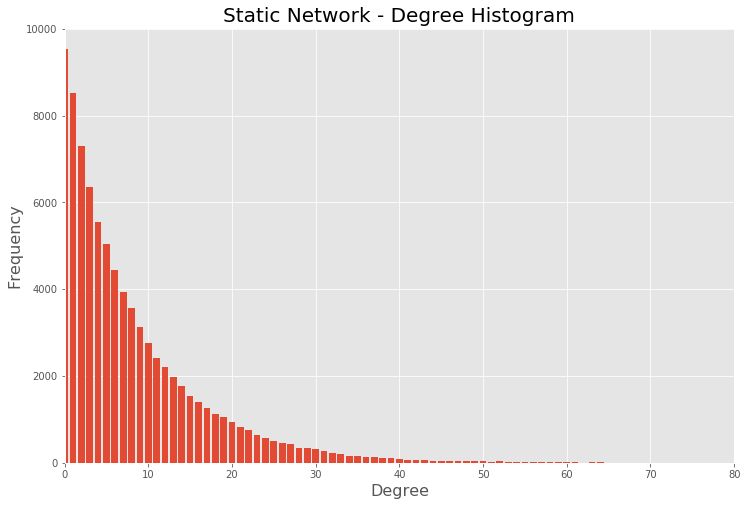

In [17]:
# Get the network degree histogram
degree_hist = nx.degree_histogram(network)[2:]

# Plot the histogram
fig = plt.figure(figsize=(12,8))
plt.bar(np.arange(len(degree_hist)), np.array(degree_hist))
plt.xlim([0,80])
plt.title('Static Network - Degree Histogram', fontsize=20)
plt.xlabel('Degree', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [18]:
f'The density of the static contact network is {nx.density(network):3f}'

'The density of the static contact network is 0.000087'

In [31]:
network.name = 'Static Contact Network'

In [38]:
nx.drawing.nx_pydot.write_dot(network, './network.dot')

In [18]:
# !sfdp -x -Goverlap=scale -Tpng network.dot > network.png

In [19]:
# nx.write_gml(network, 'network.gml')

In [ ]:
network

# OLD

In [49]:
# Set the simulated population size
population_size = 1000

# Set the population size of each area according to the real population distribution
simulation_pop_dict = {area: int(pop_proportion_dict[area]*population_size) for area in population_dict.keys()}

# Intialize a dictionary for nodes by area
nodes_by_area = {area: np.array([]) for area in population_dict.keys()}

# Intialize a Graph object
network = nx.Graph(pop_size=population_size)

# Add a node for each individual from each area
n = 0
for area, pop in tqdm(simulation_pop_dict.items()):
    # Save the nodes numbers to nodes_by_area dict
    nodes_by_area[area] = np.arange(n,n+pop)
    
    for i in range(pop):
        # Generate number of contacts
        num_of_contacts = np.random.geometric(p)
 
        # Add the node to the network (with the relevant area and number of contacts)
        network.add_node(n, area=area, contacts=num_of_contacts, remaining_contacts=num_of_contacts)
        node = network.nodes[n]
        
        # Get the number of contacts from each area (number of contacts * respective row in the contact matrix)
        # If the areas is sparse - take the contact distribution of the corresponding yeshuv/subdistrict
        if area in sparse_area_dict:
            is_sparse = True
            if sparse_area_dict[area][0] == 'subdistrict':
                contacts = (node['contacts']*contact_matrix_subdist.loc[sparse_area_dict[area][1]])
                contacts = contacts[contacts>0]
            else: 
                contacts = (node['contacts']*contact_matrix_yeshuv.loc[sparse_area_dict[area][1]])
                contacts = contacts[contacts>0]
        
        # The areas is not sparse
        else:
            is_sparse = False
            contacts = (node['contacts']*contact_matrix.loc[node['area']])
            contacts = contacts[contacts>0]
        
        # Rounding
        final_contacts = contacts.astype(int)
        
        # Remaining additional contacts due to rounding
        rem_con = node['contacts'] - final_contacts.sum()
        
        # Getting the reminder
        contacts_reminder = contacts - final_contacts
        
        # If there is a reminder in at leat one area
        if (contacts_reminder>0).any():
            # The probability of choosing the area is according to the reminder
            prob = (contacts_reminder / contacts_reminder.sum())
            # Choosing the contacts randomly according to the size of the reminder
            addinonal_contacts = np.random.choice(contacts_reminder.index, size=rem_con, replace=False, p=prob.values)
            # Adding the additional contacts
            final_contacts.loc[addinonal_contacts] += 1
            final_contacts = final_contacts[final_contacts>0]
        
        # If this is a sparse area - generate a stat area from the relevant yeshuv/subdist
        if is_sparse:
            new_cont_dict = {}
            # Go over the contacts (in yeshuv/subdist level) and poll a stat area form the yeshuv/subdist
            for cont, amount in final_contacts.iteritems():
                if sparse_area_dict[area][0] == 'yeshuv':
                    new_cont = np.random.choice(yeshuv_stat_areas[cont], size=amount, replace=True)
                else:
                    new_cont = np.random.choice(subdist_stat_areas[cont], size=amount, replace=True)
                
                # Save the number of contacts from each stat area to a dict
                for c in new_cont:
                    new_cont_dict[c] = new_cont_dict.get(c, 0) + 1
            
            # Update the final contact distribution
            final_contacts = pd.Series(new_cont_dict, dtype='int32', name=area)
            
        # Add the contact distribution to the node as an attribute
        node['contact_dist'] = final_contacts
        node['remaining_contact_dist'] = final_contacts
        
        # Incease n by 1
        n+=1

100%|██████████| 1132/1132 [00:03<00:00, 373.09it/s]


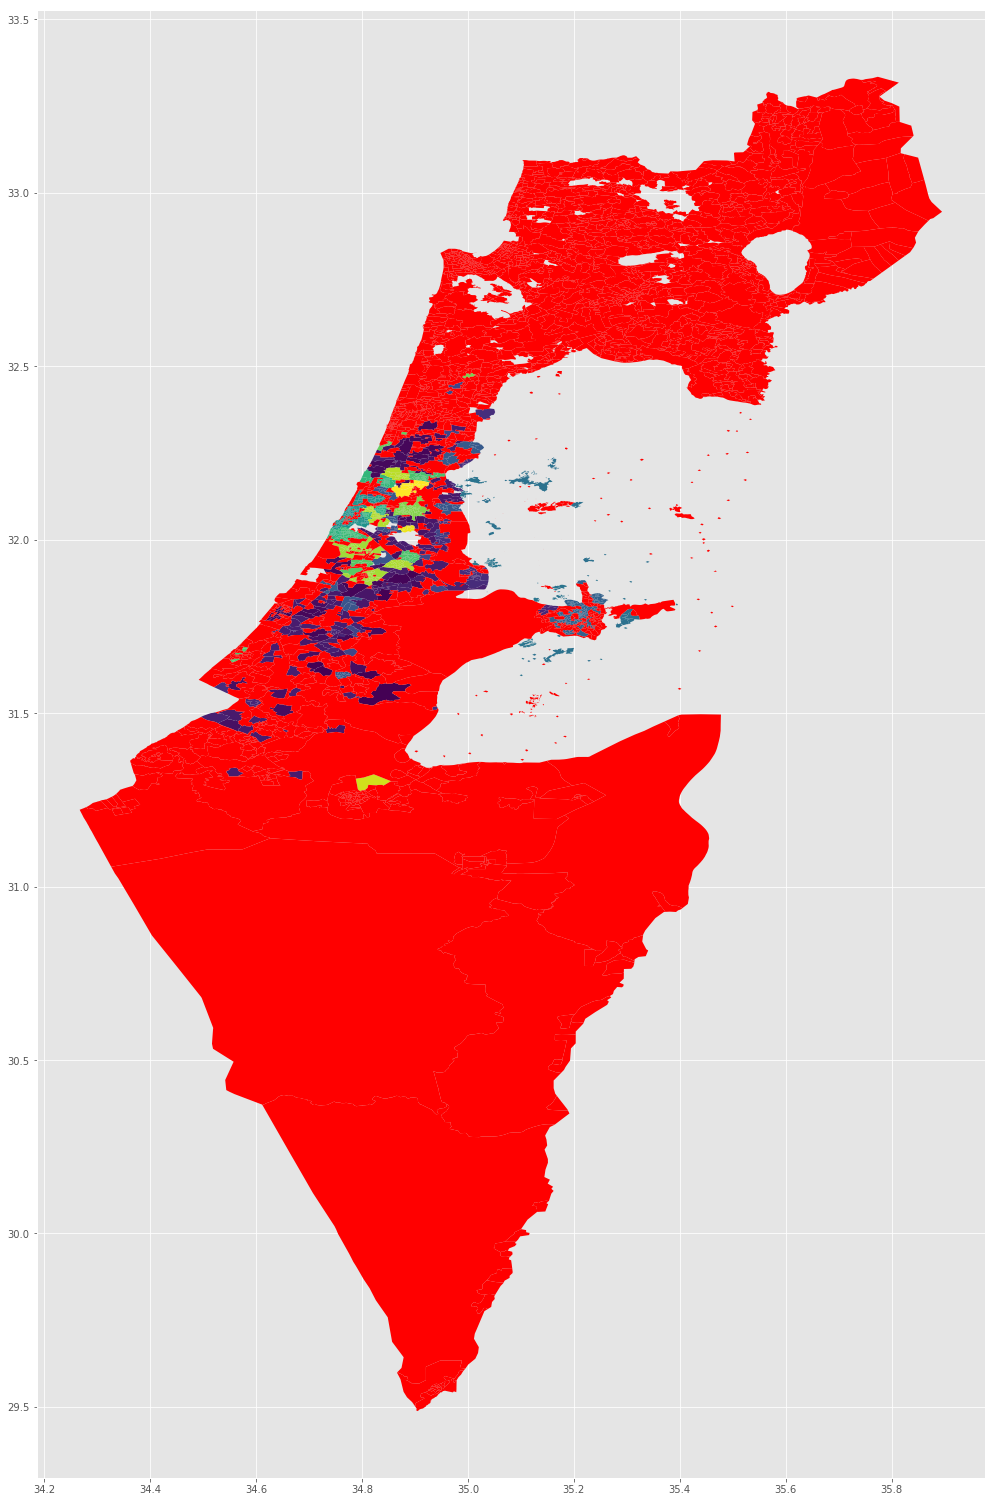

In [21]:
fig,ax = plt.subplots(figsize=(17,27))
gdf.loc[contact_matrix.index].plot(column ='SEMEL_YISH',figsize=(17,27), ax=ax)#, colormap='Accent')
gdf[(~gdf.index.isin(contact_matrix.index))].plot(color='r', ax=ax)

plt.show()

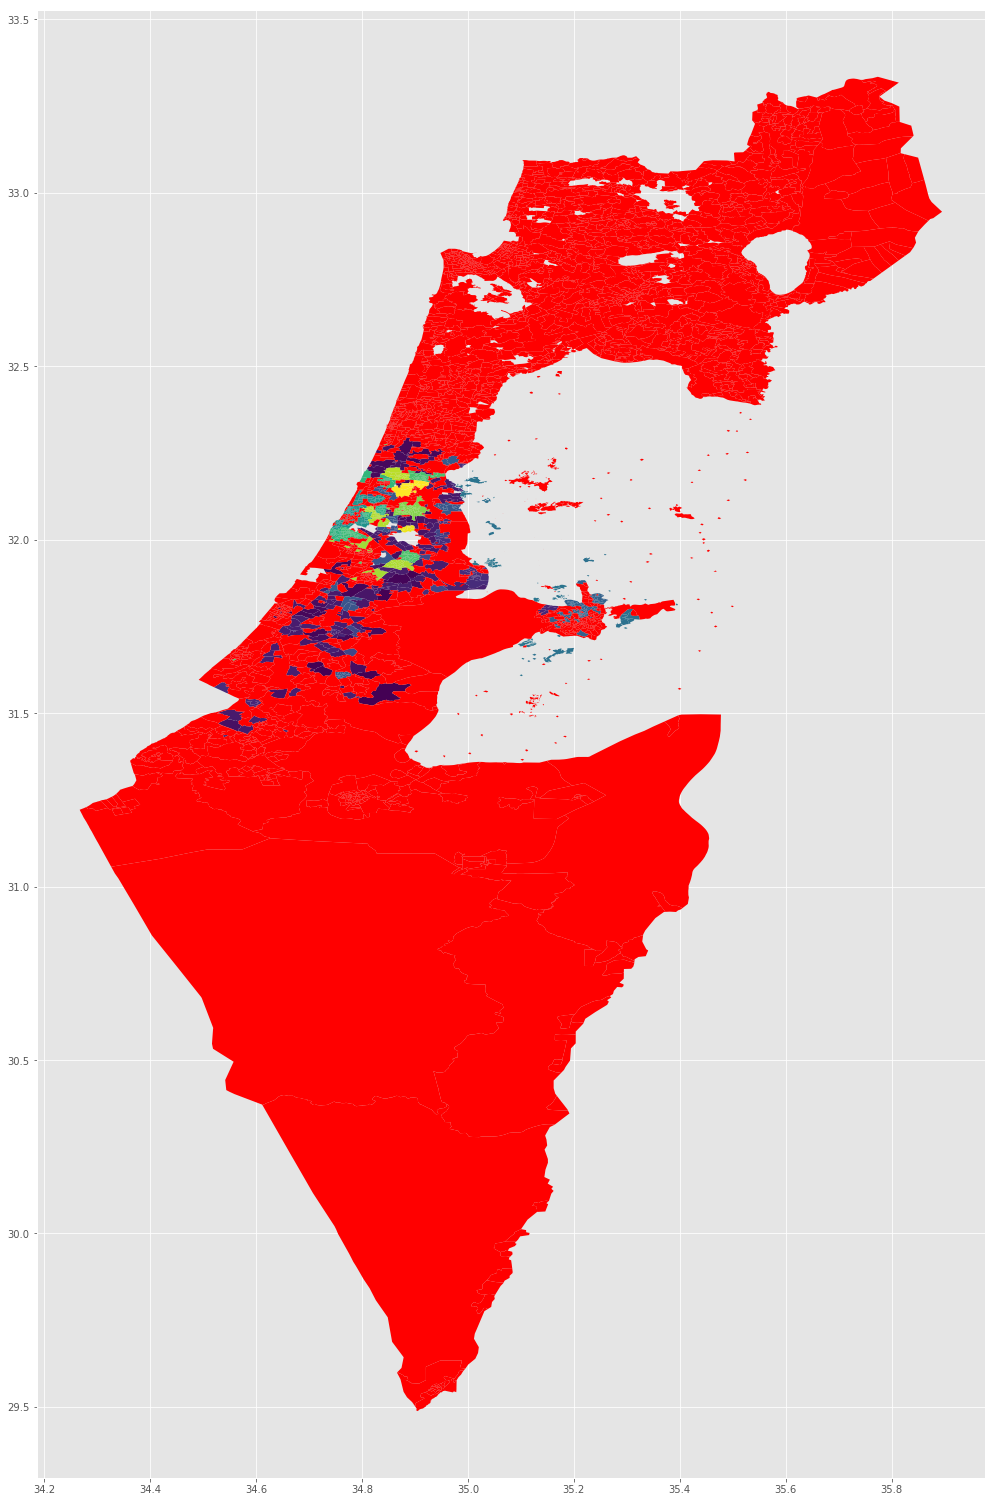

In [5]:
fig,ax = plt.subplots(figsize=(17,27))
gdf.loc[meeting_matrix.index].plot(column ='SEMEL_YISH',figsize=(17,27), ax=ax)#, colormap='Accent')
gdf[(~gdf.index.isin(meeting_matrix.index))].plot(color='r', ax=ax)

plt.show()

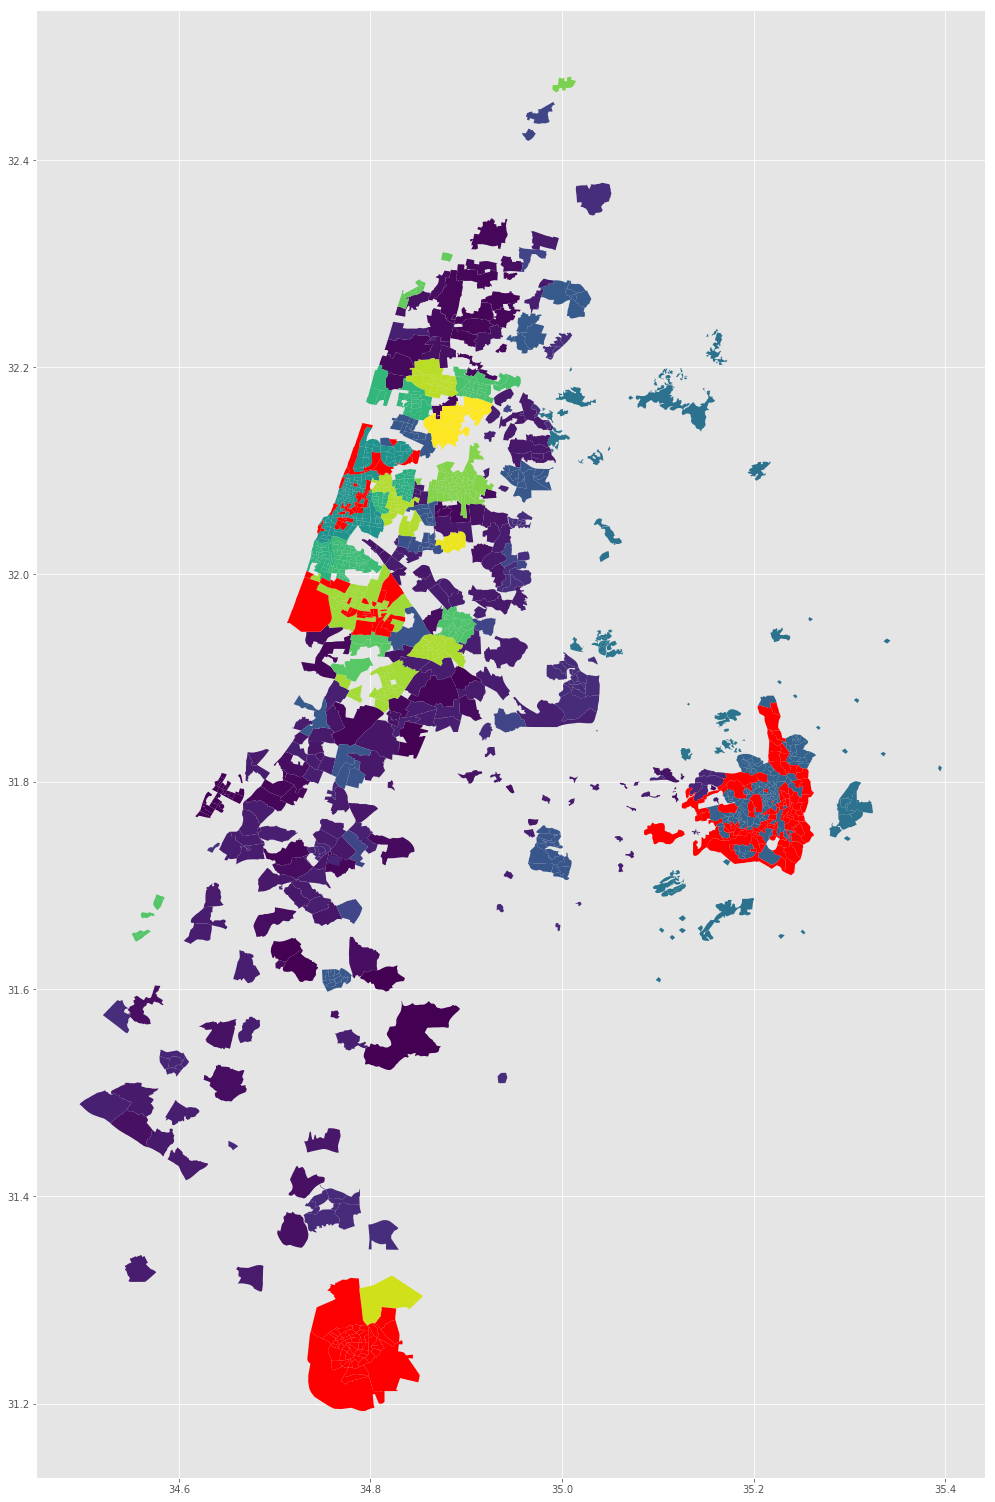

In [22]:
fig,ax = plt.subplots(figsize=(17,27))
gdf.loc[contact_matrix.index].plot(column ='SEMEL_YISH',figsize=(17,27), ax=ax)#, colormap='Accent')
gdf[(gdf.Shem_Yis_1.isin(['RISHON LEZIYYON', 'TEL AVIV - YAFO', "BE'ER SHEVA", 'JERUSALEM']))&(~gdf.index.isin(contact_matrix.index))].plot(color='r', ax=ax)
plt.show()

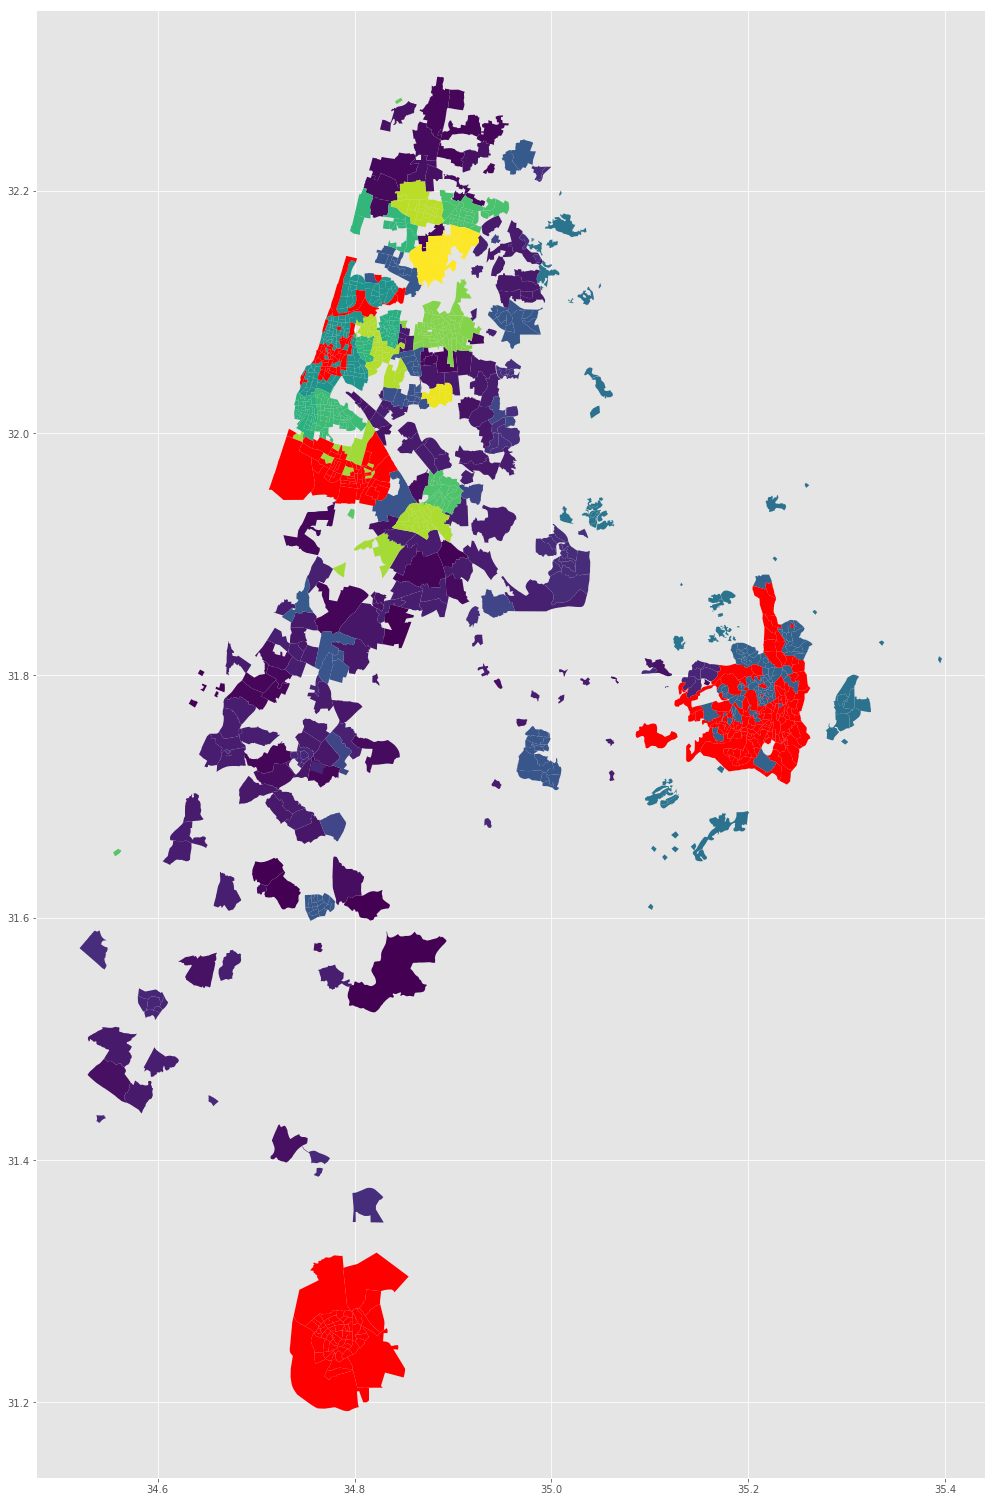

In [6]:
fig,ax = plt.subplots(figsize=(17,27))
gdf.loc[contact_matrix.index].plot(column ='SEMEL_YISH',figsize=(17,27), ax=ax)#, colormap='Accent')
gdf[(gdf.Shem_Yis_1.isin(['RISHON LEZIYYON', 'TEL AVIV - YAFO', "BE'ER SHEVA", 'JERUSALEM']))&(~gdf.index.isin(contact_matrix.index))].plot(color='r', ax=ax)
plt.show()

## OLD

In [ ]:
# Iterate over the nodes
for n in tqdm_notebook(network.nodes):
    node = network.nodes[n]
    
    # If there are no remaining contacts - continue to the next node
    if node['remaining_contacts'] == 0:
        continue
    
    # Get the number of contacts from each area (number of contacts * respective row in the contact matrix)
    contacts = (node['remaining_contacts']*contact_matrix.loc[node['area']])
    contacts = contacts[contacts>0]
    # Rounding
    final_contacts = contacts.astype(int)
    # Remaining additional contacts due to rounding
    rem_con = node['remaining_contacts'] - final_contacts.sum()
    # Getting the reminder
    contacts_reminder = contacts - final_contacts
    # The probability of choosing the area is according to the reminder
    prob = (contacts_reminder / contacts_reminder.sum())
    # Choosing the contacts randomly according to the size of the reminder
    addinonal_contacts = np.random.choice(contacts_reminder.index, size=rem_con, replace=False, p=prob.values)
    # Adding the additional contacts
    final_contacts.loc[addinonal_contacts] += 1
    
    for area, num_of_con in final_contacts.iteritems():
        # If there are enough individuals remaining form area we'll contact them. 
        # Otherwise we'll contact the remaining individuals and the rest will be from areas chosen randomly
        pool_size = (gen_nodes_dict[area].size) if area!=node['area'] else (gen_nodes_dict[area].size-1)
        cur_area_con = min(num_of_con, pool_size)
        other_areas_con = num_of_con - cur_area_con

        if cur_area_con > 0:  
            # Choose *num_of_con* individuals from *area* randomly (not including current node)
            candidates = np.delete(gen_nodes_dict[area], np.argwhere(gen_nodes_dict[area]==n))
            # Remove exisiting contacts
            for cand in candidates:
                if cand in network[n]:
                    candidates = np.delete(candidates, np.argwhere(candidates==cand))
            # If after removing there are not enough candidates
            if len(candidates) < cur_area_con:
                # Update
                cur_area_con = len(candidates)
                other_areas_con = num_of_con - cur_area_con
            
            # If there are still relevant candidates
            if len(candidates) > 0:
                contacted_individuals = np.random.choice(candidates, size=int(cur_area_con), replace=False)

                # Add an edge between node n and the chosen individuals and update the individual
                # *remaining_contacts* and dicts
                for contacted_individual in contacted_individuals:
                    add_contact(network, n, contacted_individual)
        
        # If we need to choose more areas for contact randomly
        if other_areas_con > 0:

            for i in range(int(other_areas_con)):
                candidates = nodes_list.copy()
                candidates = np.delete(candidates, np.argwhere(candidates==n))
                # Remove exisiting contacts
                for cand in candidates:
                    if cand in network[n]:
                        candidates = np.delete(candidates, np.argwhere(candidates==cand))
                    
                contacted_individual = np.random.choice(candidates)
                candidates = np.delete(candidates, np.argwhere(candidates==contacted_individual))
                add_contact(network, n, contacted_individual)

    
    # Update node's *remaining_contacts* to 0 and update the dicts
    node['remaining_contacts'] = 0
    
    # Update nodes list
    nodes_list = np.delete(nodes_list, np.argwhere(nodes_list==n))
    
    # Update nodes_dict
    if np.argwhere(gen_nodes_dict[node['area']]==n).size==0:
        print('12342432')
    gen_nodes_dict[node['area']] = np.delete(gen_nodes_dict[node['area']], np.argwhere(gen_nodes_dict[node['area']]==n))
    
    # Update pop_dict
    gen_pop_dict[node['area']] -= 1
    if gen_pop_dict[node['area']] == 0:
        p=gen_pop_dict.pop(node['area'])

In [ ]:
# nodes_list = np.array(list(network.nodes))
gen_nodes_dict = nodes_by_area_age.copy()
# gen_pop_dict = {}
# for area, pop in simulation_pop_dict.items():
#     if simulation_pop_dict[area] > 0:
#         gen_pop_dict[area] = pop

def add_contact(network, node, individual, con_location=None):#, update=True, nodes_dict=gen_nodes_dict,
#                  pop_dict=gen_pop_dict, node_list=nodes_list):
    
    # Iterate over the individuals to be connected with
    if (n, individual) in network.edges:
        print ('CRAPPPPPPPPPPPPPPPPPP',  (n, individual))
    # Add the edge and update the number of remaining contacts
    network.add_edge(n, individual, location=con_location)
    network.nodes[individual]['remaining_contacts'] -= 1
    # Update remaining_contact_distribution
    network.nodes[individual]['remaining_contact_dist'][network.nodes[n]['area']] -= 1 
    # If one of the areas in remaining_contact_dist is now 0, remove it
    network.nodes[individual]['remaining_contact_dist'] =\
                    network.nodes[individual]['remaining_contact_dist'][network.nodes[individual]['remaining_contact_dist']>0]

    # If the number of remaining contacts is now zero - remove from meeting_gen_dict and update gen_pop_dict
    if network.nodes[individual]['remaining_contacts'] == 0:
        # Get the individual's area
        area = network.nodes[individual]['area']
        # Update nodes_dict
        if np.argwhere(gen_nodes_dict[area]==individual).size == 0:
            gen_nodes_dict[area] = np.delete(gen_nodes_dict[area], np.argwhere(gen_nodes_dict[area]==individual))
        
        # Update nodes list
#         node_list = np.delete(nodes_list, np.argwhere(nodes_list==individual))
        
#         # Update pop_dict
#         gen_pop_dict[area] -= 1
#         if gen_pop_dict[area] == 0:
#             p=gen_pop_dict.pop(area)